In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives, calc_decay_windows, _halflife
from jtb_2022_code import FigureSingleCellData
from inferelator_prior.velocity import decay
import numpy as np
import pandas as pd

In [3]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()

data.apply_inplace_to_expts(do_pca_pt, pca_key="denoised_pca", pt_key="denoised_pca_pt")
data.apply_inplace_to_expts(do_time_assign_by_pool)
data.load_pseudotime(do_rho=False)

data.apply_inplace_to_expts(calculate_times_velocities, 
                            layer='denoised',
                            transform_expr=np.expm1,
                            pt_obs_key='pca_pt',
                            distance_key='denoised_distances', 
                            force=False)

data.apply_inplace_to_expts(calc_decays)
data.apply_inplace_to_expts(calc_halflives)
#data.apply_inplace_to_expts(calc_decay_windows, 80)
#data.save()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [ ]:
#data.load_pseudotime(do_rho=True)

#data.expt_data[(1, "WT")]
data.expt_data[(1, "fpr1")].obs['Replicate'].value_counts()

In [ ]:
data.apply_inplace_to_expts(calc_decay_windows, force=False, include_alpha=True, decay_quantiles=(0.00, 0.05), bootstrap=True)

In [ ]:
data.save()

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats

KeyboardInterrupt: 

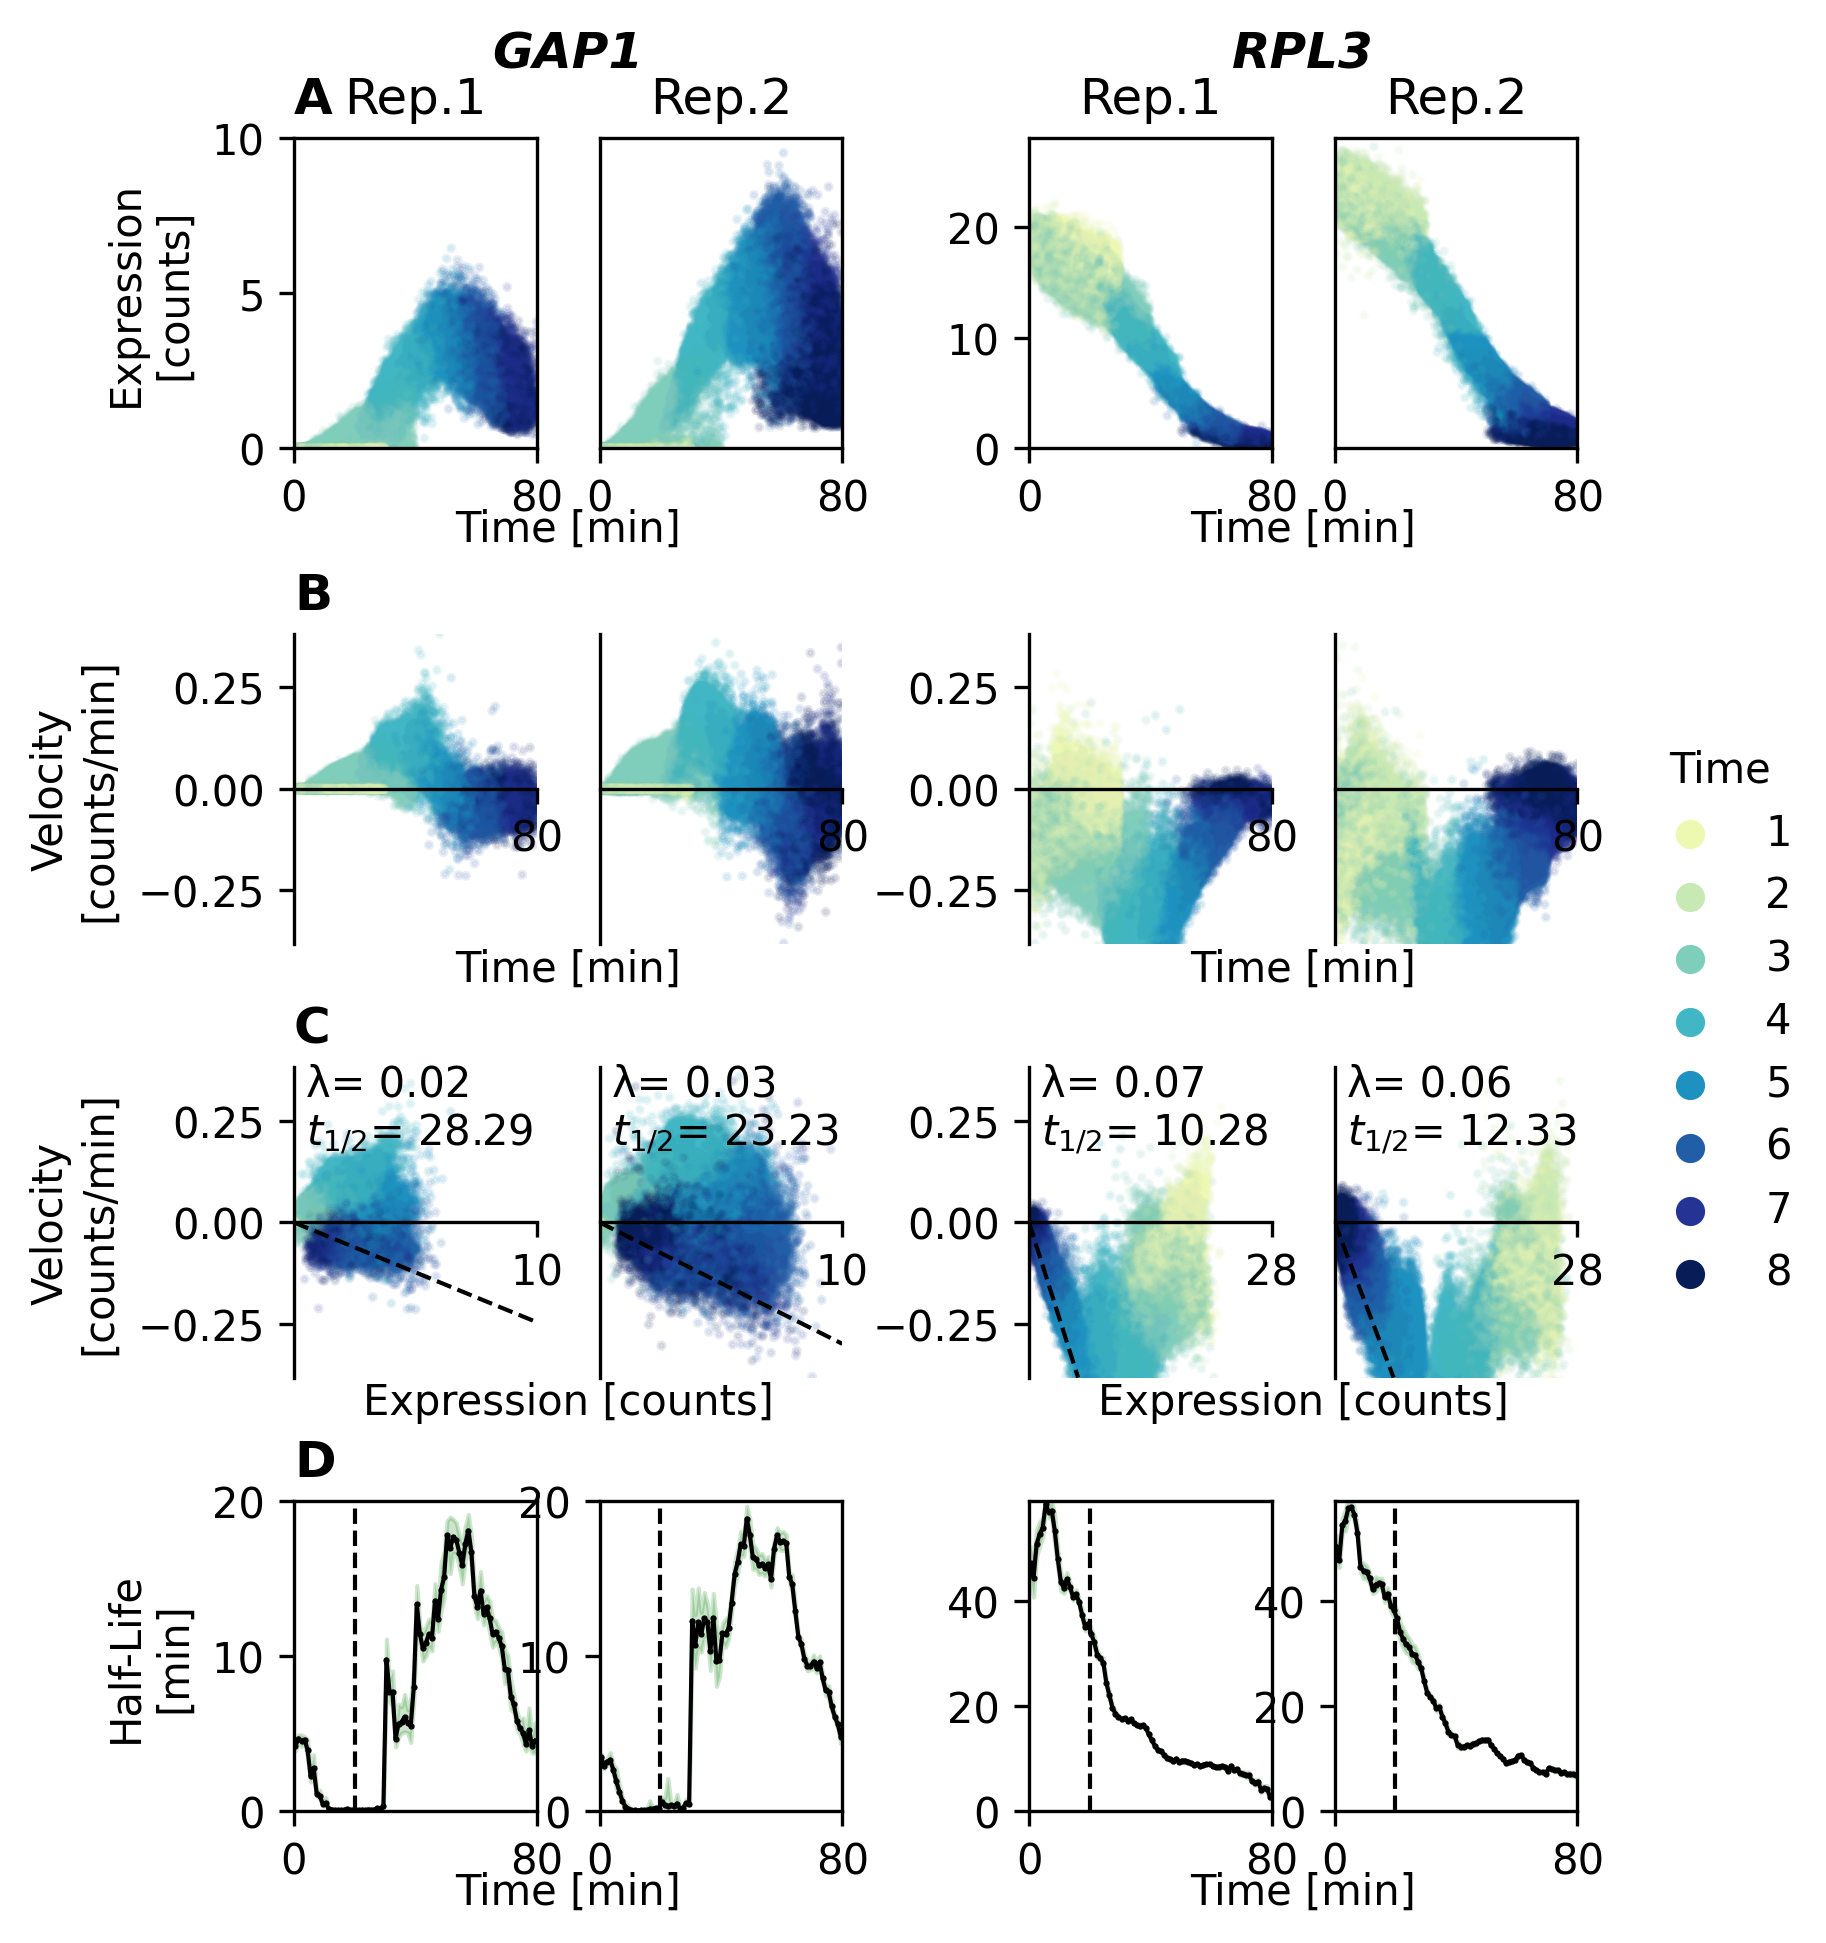

In [29]:
rgen = np.random.default_rng(100)

panel_genes = ["YKR039W", "YOR063W"]

panel_labels = {'expr_11': "A",
                'velocity_11': "B",
                'decay_11': "C",
                'decaytime_11': "D"}

panel_titles = {'title_1': data.gene_common_name(panel_genes[0]),
                'title_2': data.gene_common_name(panel_genes[1])}

x_axis_labelers = {'x_lab_11': ('Time [min]', 0), 
                   'x_lab_21': ('Time [min]', 0.9), 
                   'x_lab_31': ('Expression [counts]', 0.9), 
                   'x_lab_12': ('Time [min]', 0), 
                   'x_lab_22': ('Time [min]', 0.9), 
                   'x_lab_32': ('Expression [counts]', 0.9),
                   'x_lab_41': ('Time [min]', 0),
                   'x_lab_42': ('Time [min]', 0)}

layout = [['title_1', 'title_1', '.', 'title_2', 'title_2', '.'],
          ['expr_11', 'expr_21', '.', 'expr_12', 'expr_22', 'time_lgd'],
          ['x_lab_11', 'x_lab_11', '.', 'x_lab_12', 'x_lab_12', 'time_lgd'],
          ['.'] * 5 + ['time_lgd'],
          ['velocity_11', 'velocity_21', '.', 'velocity_12', 'velocity_22', 'time_lgd'],
          ['x_lab_21', 'x_lab_21', '.', 'x_lab_22', 'x_lab_22', 'time_lgd'],
          ['decay_11', 'decay_21', '.', 'decay_12', 'decay_22', 'time_lgd'],
          ['x_lab_31', 'x_lab_31', '.', 'x_lab_32', 'x_lab_32', 'time_lgd'],
          ['decaytime_11', 'decaytime_21', '.', 'decaytime_12', 'decaytime_22', 'time_lgd'],
          ['x_lab_41', 'x_lab_41', '.', 'x_lab_42', 'x_lab_42', 'time_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 0.25, 1, 1, 0.2], 
                                               height_ratios=[0.05, 1, 0.2, 0.1, 1, 0.2, 1, 0.2, 1, 0.2],
                                               wspace=0.35), 
                              figsize=(6, 8), dpi=300)

def _minmax(arr):
    return np.nanmin(arr), np.nanmax(arr)

def _minmax_list(lst):
    return min(l[0] for l in lst), max(l[1] for l in lst)

def _get_limits(layer, mod_func=lambda x: x, symmetric=False):
    limits = {g: _minmax_list([_minmax(mod_func(data.expt_data[(j, k)].layers[layer][:, data.expt_data[(j, k)].var_names == g])) 
                              for j in range(1, 3) 
                              for k in ["WT"]]) 
              for g in panel_genes}
    
    if not symmetric:
        return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
    else:
        return {g: (-1 * np.max(v), np.max(v)) for g, v in limits.items()}
    
def _get_halflife_limits(decay_key='decay_windows', se_key='decay_windows_se', max_halflife=120):
    limits = {g: _minmax_list([_minmax(_halflife(data.expt_data[(j, k)].varm[decay_key][data.expt_data[(j, k)].var_names == g, :].flatten() -
                                                 data.expt_data[(j, k)].varm[se_key][data.expt_data[(j, k)].var_names == g, :].flatten()))
                             for j in range(1, 3) 
                             for k in ["WT"]]) for g in panel_genes}
    return {g: (0, np.ceil(min(max_halflife, v[1]))) for g, v in limits.items()}

expr_limits = _get_limits('denoised', mod_func = np.expm1)
velocity_limits = _get_limits('denoised_velocity', symmetric=True)
halflife_limits = _get_halflife_limits()

for a in ['title_1', 'title_2', 'time_lgd']:
    axd[a].axis('off')
    
for axid, (lab, yoff) in x_axis_labelers.items():
    axd[axid].axis('off')
    axd[axid].annotate(lab, (0.5, yoff), xycoords='axes fraction', ha='center')

def _replot_axes(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
               
for j in range(1, 3):
    pdata = data.expt_data[(j, "WT")]
    for i, g in enumerate(panel_genes):
        g_idx = pdata.var_names == g
        
        overplot_shuffle = np.arange(pdata.shape[0])
        rgen.shuffle(overplot_shuffle)
        
        time_data = pdata.obs['time_pca_pt'].values[overplot_shuffle]
        
        expr_data = np.expm1(pdata.layers['denoised'][:, g_idx]).flatten()[overplot_shuffle]
        #expr_data = pdata.X[:, g_idx].A.flatten()[overplot_shuffle].astype(float)
        #_umis = pdata.X.sum(axis=1).A1
        #expr_data /= _umis 
        #expr_data *= np.median(_umis)
        
        velocity_data = pdata.layers['denoised_velocity'][:, g_idx].flatten()[overplot_shuffle]
        color_data = pdata.obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values[overplot_shuffle]
        
        ### PANEL A ###
        a_ref = "expr_" + str(j) + str(i + 1)
        fig_refs[a_ref] = axd[a_ref].scatter(x=time_data, 
                                             y=expr_data,
                                             c=color_data,
                                             alpha=0.1, 
                                             s=2)
        axd[a_ref].set_xlim(0, 80)
        axd[a_ref].set_xticks([0, 80])
        axd[a_ref].set_ylim(*expr_limits[g])
        axd[a_ref].set_yticks([]) if j == 2 else None
        axd[a_ref].set_ylabel("Expression\n[counts]") if j == 1 and i == 0 else None
        axd[a_ref].set_title("Rep." + str(j))
        
        ### PANEL B ###
        b_ref = "velocity_" + str(j) + str(i + 1)
        fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.1, 
                                             s=2)
        
        axd[b_ref].set_xlim(0, 80)
        axd[b_ref].set_xticks([80])
        axd[b_ref].set_ylim(*velocity_limits[g])
        axd[b_ref].set_yticks([]) if j == 2 else None
        axd[b_ref].set_ylabel("Velocity\n[counts/min]") if j == 1 and i == 0 else None

        _replot_axes(axd[b_ref])
        
        ### PANEL C ###
        c_ref = "decay_" + str(j) + str(i + 1)
        fig_refs[c_ref] = axd[c_ref].scatter(x=expr_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.1, 
                                             s=2)
        
        axd[c_ref].set_xlim(*expr_limits[g])
        axd[c_ref].set_xticks([expr_limits[g][1]])
        axd[c_ref].set_ylim(*velocity_limits[g])
        axd[c_ref].set_yticks([]) if j == 2 else None
        axd[c_ref].set_ylabel("Velocity\n[counts/min]") if j == 1 and i == 0 else None

        _replot_axes(axd[c_ref])
        
        decay_constant = pdata.var.loc[g_idx, 'decay'][0]
        half_life = np.log(2) / decay_constant
        axd[c_ref].axline((0, 0), slope = -1 * decay_constant, c="black", linestyle='--', linewidth=1.0)
        axd[c_ref].annotate(f"λ= {decay_constant:.2f}\n" + "$t_{1/2}$= " + f"{half_life:.2f}", 
                            xy=(5, 0.2),  xycoords='data', xytext=(0.05, 0.75), textcoords='axes fraction')
        
        ### PANEL D ###
        d_ref = "decaytime_" + str(j) + str(i + 1)
        times = pdata.uns['decay_windows']['times']
        decays = pdata.varm['decay_windows'][g_idx, :].flatten()
        decays_ci = pdata.varm['decay_windows_se'][g_idx, :].flatten() * 1.96
        
        axd[d_ref].plot(times, _halflife(decays), marker=".", linestyle='-', linewidth=1.0, markersize=1, c='black')
        axd[d_ref].set_xlim(0, 80)
        axd[d_ref].set_xticks([0, 80])
        axd[d_ref].set_ylim(*halflife_limits[g])
        
        axd[d_ref].fill_between(times, _halflife(decays + decays_ci), _halflife(decays - decays_ci), alpha=0.2, color='green')
        
        axd[d_ref].axvline(20, 0, 1, linestyle='--', linewidth=1.0, c='black')
        axd[d_ref].set_ylabel("Half-Life\n[min]") if j == 1 and i == 0 else None
        
fig_refs['time_lgd'] = add_legend(axd['time_lgd'], 
                                  pool_palette(), 
                                  data.all_data.obs['Pool'].dtype.categories.values,
                                  title="Time")

### Half-life correlation plot ###
"""
hl_x = data.expt_data[(1, "WT")].var['halflife']
hl_y = data.expt_data[(2, "WT")].var['halflife']
drop_na_idx = hl_x.isna() | hl_y.isna()
hl_x = hl_x.loc[~drop_na_idx]
hl_y = hl_y.loc[~drop_na_idx]

hl_rho = scipy.stats.spearmanr(hl_x, hl_y)[0]
fig_refs['hl_corr'] = axd['hl_corr'].scatter(x=hl_x, y=hl_y, 
                                             c='black', alpha=0.2, marker='.')
axd['hl_corr'].set_xlabel("Expt 1. $t_{1/2}$ [min]")
axd['hl_corr'].set_ylabel("Expt 2. $t_{1/2}$ [min]")
axd['hl_corr'].set_xlim(0, 20)
axd['hl_corr'].set_ylim(0, 20)
axd['hl_corr'].axline((0, 0), slope = 1, c='red', linestyle='--', linewidth=1.0)
axd['hl_corr'].annotate(f"ρ= {hl_rho:.2f}",
                        xy=(5, 0.2),  xycoords='data', xytext=(0.45, 0.05), textcoords='axes fraction')

# Half-life correlation / time plots
"""

for ax_id, label in panel_titles.items():
    axd[ax_id].set_title(label, fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
fig.savefig(FIGURE_3_FILE_NAME + ".png", facecolor='white')
        

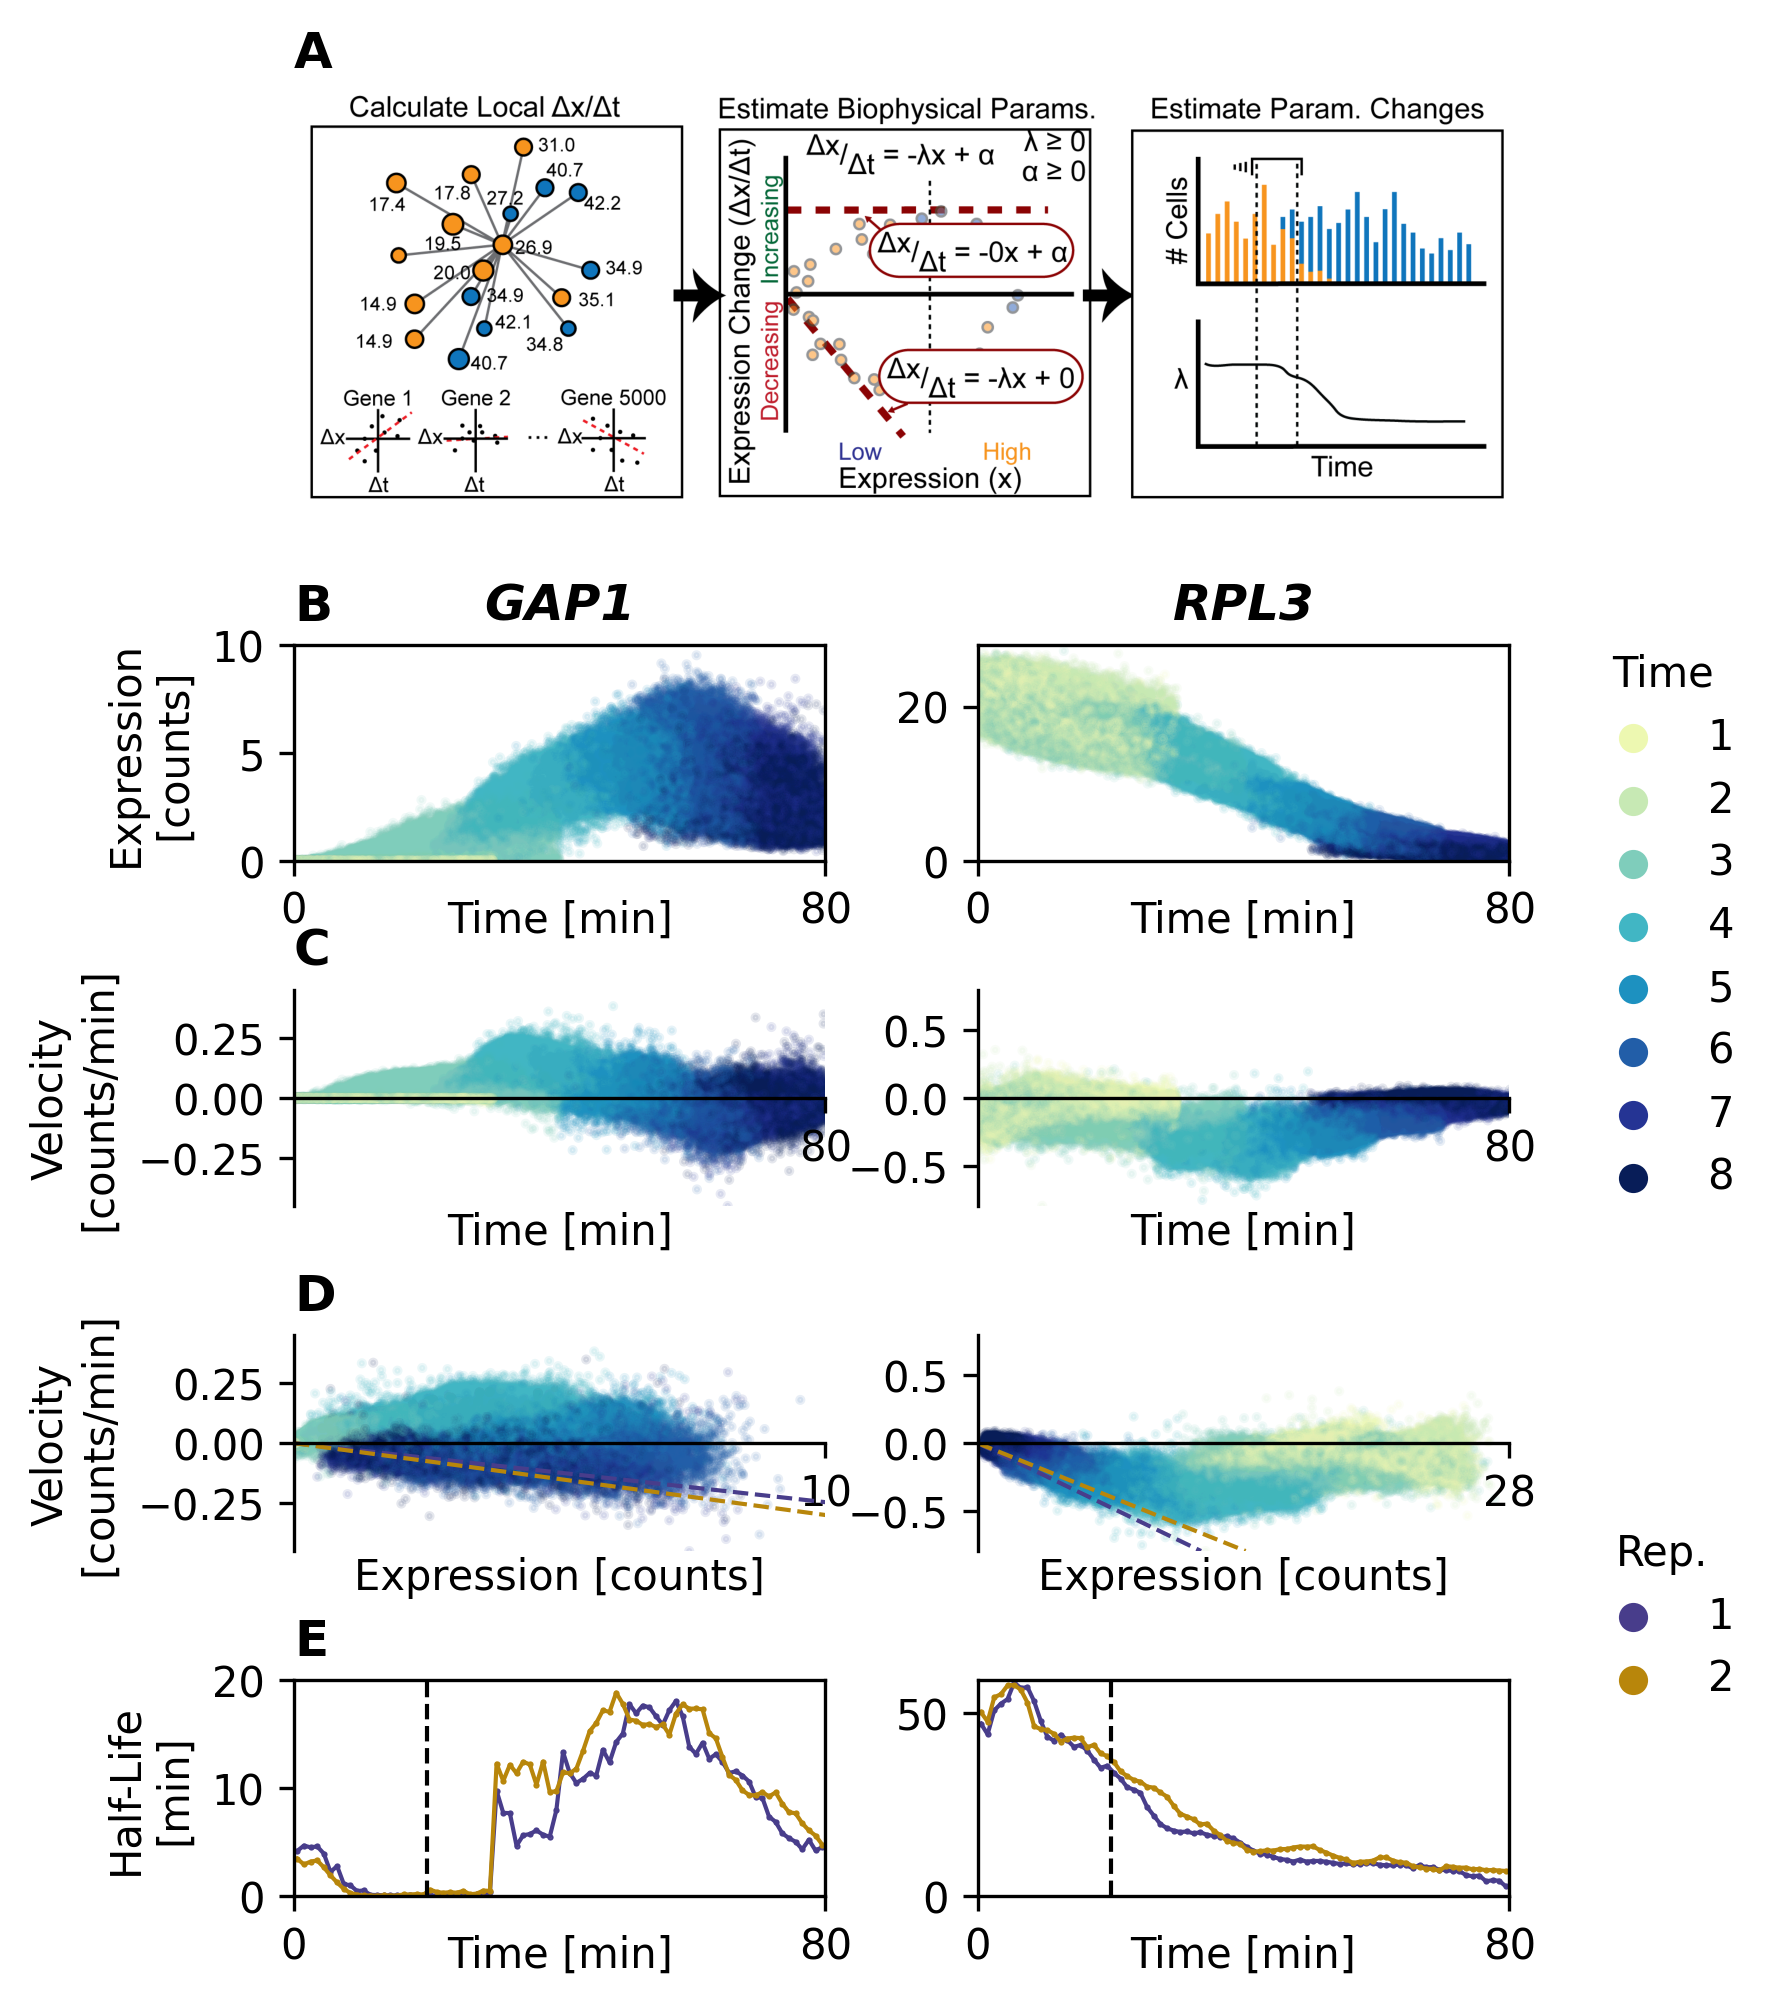

In [82]:
rgen = np.random.default_rng(100)

rep_colors = ['darkslateblue', 'darkgoldenrod']

panel_genes = ["YKR039W", "YOR063W"]

panel_labels = {'schematic': "A",
                'expr_1': "B",
                'velocity_1': "C",
                'decay_1': "D",
                'decaytime_1': "E"}

layout = [['schematic', 'schematic', 'schematic', '.'],
          ['expr_1', '.', 'expr_2', 'time_lgd'],
          ['velocity_1', '.', 'velocity_2', 'time_lgd'],
          ['decay_1', '.', 'decay_2', 'rep_lgd'],
          ['decaytime_1', '.', 'decaytime_2', 'rep_lgd']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                               height_ratios=[2, 1, 1, 1, 1],
                                               wspace=0.25, hspace=0.5), 
                              figsize=(6, 8), dpi=300)

fig_refs['schematic'] = axd['schematic'].imshow(plt.imread(FIG3A_FILE_NAME), aspect='equal')

def _minmax(arr):
    return np.nanmin(arr), np.nanmax(arr)

def _minmax_list(lst):
    return min(l[0] for l in lst), max(l[1] for l in lst)

def _get_limits(layer, mod_func=lambda x: x, symmetric=False):
    limits = {g: _minmax_list([_minmax(mod_func(data.expt_data[(j, k)].layers[layer][:, data.expt_data[(j, k)].var_names == g])) 
                              for j in range(1, 3) 
                              for k in ["WT"]]) 
              for g in panel_genes}
    
    if not symmetric:
        return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
    else:
        return {g: (-1 * np.max(np.abs(v)), np.max(np.abs(v))) for g, v in limits.items()}
    
def _get_halflife_limits(decay_key='decay_windows', se_key='decay_windows_se', max_halflife=120):
    limits = {g: _minmax_list([_minmax(_halflife(data.expt_data[(j, k)].varm[decay_key][data.expt_data[(j, k)].var_names == g, :].flatten() -
                                                 data.expt_data[(j, k)].varm[se_key][data.expt_data[(j, k)].var_names == g, :].flatten()))
                             for j in range(1, 3) 
                             for k in ["WT"]]) for g in panel_genes}
    return {g: (0, np.ceil(min(max_halflife, v[1]))) for g, v in limits.items()}

expr_limits = _get_limits('denoised', mod_func = np.expm1)
velocity_limits = _get_limits('denoised_velocity', symmetric=True)
halflife_limits = _get_halflife_limits()

for a in ['time_lgd', 'rep_lgd', 'schematic']:
    axd[a].axis('off')
    
def _replot_axes(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    
def _gene_data(gene, t_key='time_pca_pt', layer='denoised'):    
    g_data = np.concatenate([data.expt_data[(i, "WT")].layers[layer][:, data.expt_data[(i, "WT")].var_names == gene].flatten()
                             for i in range(1, 3)])
    t_data = np.concatenate([data.expt_data[(i, "WT")].obs['time_pca_pt'].values
                             for i in range(1, 3)])
    pools = np.concatenate([data.expt_data[(i, "WT")].obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values
                            for i in range(1, 3)])

    return g_data, t_data, pools

def _decay_data(gene):
    decays = [data.expt_data[(i, "WT")].varm['decay_windows'][data.expt_data[(i, "WT")].var_names == gene, :].flatten()
              for i in range(1, 3)]
    times = data.expt_data[(1, "WT")].uns['decay_windows']['times']
    
    dcs = [data.expt_data[(i, "WT")].var.loc[data.expt_data[(i, "WT")].var_names == gene, 'decay'][0]
           for i in range(1, 3)]
    
    return decays, times, dcs
    
    
for i, g in enumerate(panel_genes):
    expr_data, time_data, color_data = _gene_data(g)
    velocity_data, _, _ = _gene_data(g, layer='denoised_velocity')
    expr_data = np.expm1(expr_data)
    
    overplot_shuffle = np.arange(expr_data.shape[0])
    rgen.shuffle(overplot_shuffle)

    expr_data = expr_data[overplot_shuffle]
    time_data = time_data[overplot_shuffle]
    color_data = color_data[overplot_shuffle]
    velocity_data = velocity_data[overplot_shuffle]

    ### PANEL A ###
    a_ref = "expr_" + str(i + 1)
    fig_refs[a_ref] = axd[a_ref].scatter(x=time_data, 
                                         y=expr_data,
                                         c=color_data,
                                         alpha=0.1, 
                                         s=2)
    axd[a_ref].set_xlim(0, 80)
    axd[a_ref].set_xticks([0, 80])
    axd[a_ref].set_ylim(*expr_limits[g])
    axd[a_ref].set_ylabel("Expression\n[counts]") if i == 0 else None
    axd[a_ref].set_xlabel("Time [min]", labelpad=-8)
    axd[a_ref].set_title(data.gene_common_name(g), 
                         fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})
    
    ### PANEL B ###
    b_ref = "velocity_" + str(i + 1)
    fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                         y=velocity_data,
                                         c=color_data,
                                         alpha=0.1, 
                                         s=2) 

    axd[b_ref].set_xlim(0, 80)
    axd[b_ref].set_xticks([80])
    axd[b_ref].set_ylim(*velocity_limits[g])
    axd[b_ref].set_ylabel("Velocity\n[counts/min]") if i == 0 else None
    axd[b_ref].set_xlabel("Time [min]", labelpad=10)

    _replot_axes(axd[b_ref])
    
    ### PANEL C ###
    c_ref = "decay_" + str(i + 1)
    decays, times, decay_consts = _decay_data(g)

    
    fig_refs[c_ref] = axd[c_ref].scatter(x=expr_data, 
                                         y=velocity_data,
                                         c=color_data,
                                         alpha=0.1, 
                                         s=2)

    axd[c_ref].set_xlim(*expr_limits[g])
    axd[c_ref].set_xticks([expr_limits[g][1]])
    axd[c_ref].set_ylim(*velocity_limits[g])
    axd[c_ref].set_ylabel("Velocity\n[counts/min]") if i == 0 else None
    axd[c_ref].set_xlabel("Expression [counts]", labelpad=10)


    for rc, dc in zip(rep_colors, decay_consts):
        axd[c_ref].axline((0, 0), slope = -1 * dc, c=rc, linestyle='--', linewidth=1.0)
    
    _replot_axes(axd[c_ref])
    
    ### PANEL D ###
    d_ref = "decaytime_" + str(i + 1)

    for ic, i_decays in zip(rep_colors, decays):
        axd[d_ref].plot(times, _halflife(i_decays), marker=".", linestyle='-', linewidth=1.0, markersize=1, c=ic)
        
    axd[d_ref].set_xlim(0, 80)
    axd[d_ref].set_xticks([0, 80])
    axd[d_ref].set_ylim(*halflife_limits[g])

    axd[d_ref].axvline(20, 0, 1, linestyle='--', linewidth=1.0, c='black')
    axd[d_ref].set_ylabel("Half-Life\n[min]") if i == 0 else None
    axd[d_ref].set_xlabel("Time [min]", labelpad=-8)


fig_refs['time_lgd'] = add_legend(axd['time_lgd'], 
                                  pool_palette(), 
                                  data.all_data.obs['Pool'].dtype.categories.values,
                                  title="Time")

fig_refs['time_lgd'] = add_legend(axd['rep_lgd'], 
                                  rep_colors, 
                                  data.all_data.obs['Experiment'].dtype.categories.values,
                                  title="Rep.")

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(label, loc='left', weight='bold')

fig.savefig(FIGURE_3_FILE_NAME + ".png", facecolor='white', bbox_inches='tight')        

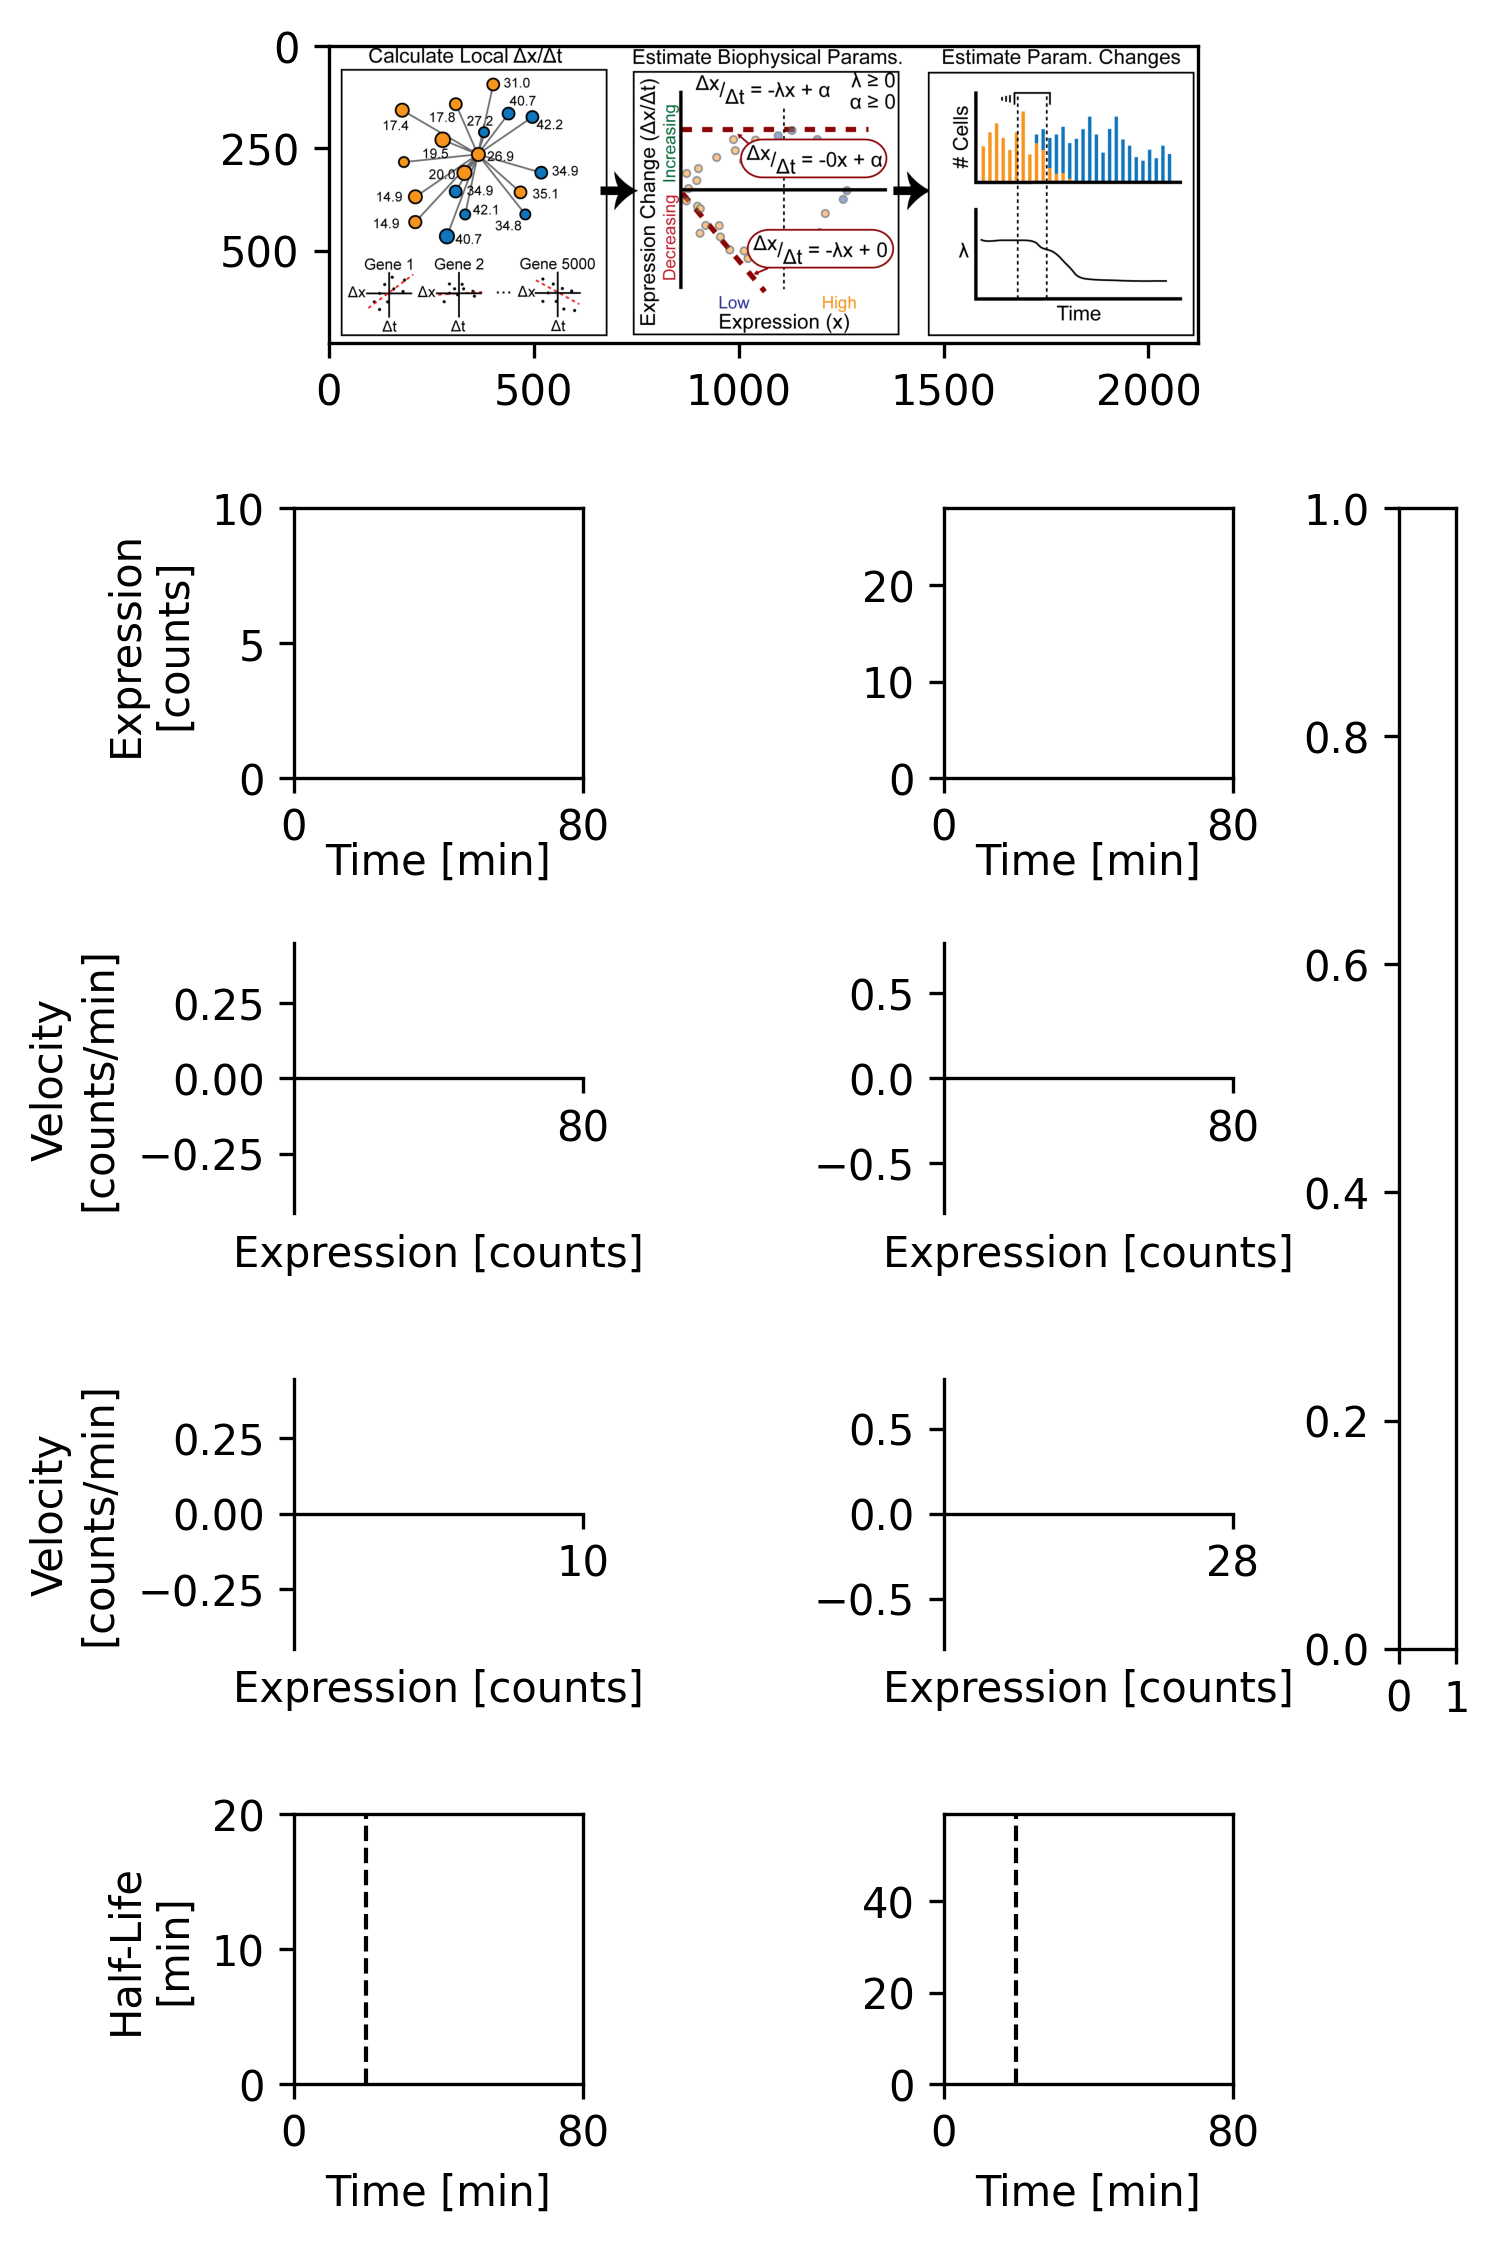

In [63]:
rgen = np.random.default_rng(100)

rep_colors = ['darkslateblue', 'darkgoldenrod']

panel_genes = ["YKR039W", "YOR063W"]

panel_labels = {'schematic': "A",
                'expr_1': "B",
                'velocity_1': "C",
                'decay_1': "D",
                'decaytime_1': "E"}

layout = [['schematic', 'schematic', 'schematic', '.'],
          ['expr_1', '.', 'expr_2', 'time_lgd'],
          ['velocity_1', '.', 'velocity_2', 'time_lgd'],
          ['decay_1', '.', 'decay_2', 'time_lgd'],
          ['decaytime_1', '.', 'decaytime_2', '.']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.1, 1, 0.2], 
                                               height_ratios=[1.1, 1, 1, 1, 1],
                                               wspace=1, hspace=0.6), 
                              figsize=(5, 9), dpi=300)

fig_refs['schematic'] = axd['schematic'].imshow(plt.imread(FIG3A_FILE_NAME), aspect='equal')

def _shift_xaxis_y(ax, shift):
    label = ax.xaxis.get_label()
    x, y = label.get_position()
    label.set_position([x, y + shift])
    ax.xaxis.set_label(label)
    
for i, g in enumerate(panel_genes):

    ### PANEL A ###
    a_ref = "expr_" + str(i + 1)
    axd[a_ref].set_xlim(0, 80)
    axd[a_ref].set_xticks([0, 80])
    axd[a_ref].set_ylim(*expr_limits[g])
    axd[a_ref].set_ylabel("Expression\n[counts]") if i == 0 else None
    axd[a_ref].set_xlabel("Time [min]", labelpad=-2)
    
    ### PANEL B ###
    b_ref = "velocity_" + str(i + 1)

    axd[b_ref].set_xlim(0, 80)
    axd[b_ref].set_xticks([80])
    axd[b_ref].set_ylim(*velocity_limits[g])
    axd[b_ref].set_ylabel("Velocity\n[counts/min]") if i == 0 else None
    axd[b_ref].set_xlabel("Expression [counts]", labelpad=20)

    _replot_axes(axd[b_ref])
    
    ### PANEL C ###
    c_ref = "decay_" + str(i + 1)

    axd[c_ref].set_xlim(*expr_limits[g])
    axd[c_ref].set_xticks([expr_limits[g][1]])
    axd[c_ref].set_ylim(*velocity_limits[g])
    axd[c_ref].set_ylabel("Velocity\n[counts/min]") if i == 0 else None
    axd[c_ref].set_xlabel("Expression [counts]", labelpad=20)
    
    _replot_axes(axd[c_ref])
    
    ### PANEL D ###
    d_ref = "decaytime_" + str(i + 1)

    axd[d_ref].set_xlim(0, 80)
    axd[d_ref].set_xticks([0, 80])
    axd[d_ref].set_ylim(*halflife_limits[g])

    axd[d_ref].axvline(20, 0, 1, linestyle='--', linewidth=1.0, c='black')
    axd[d_ref].set_ylabel("Half-Life\n[min]") if i == 0 else None
    axd[d_ref].set_xlabel("Time [min]")


In [50]:


axd[a_ref].xaxis.get_label().get_position()

(0.5, 1306.6673669467787)